In [182]:
#必要なパッケージのインポート

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

from scipy.integrate import solve_ivp
import pandas as pd
from reservoirpy.observables import nrmse, rsquare

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

%time

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.1 µs


In [183]:
filename = 'rossler_data.csv'

# CSVファイルを読み込む
data_loaded = pd.read_csv(filename)

# CSVから値を抽出してNumpy配列に格納
X = data_loaded[['x', 'y']].values

print(X)


[[ 1.00000000e+00  0.00000000e+00]
 [ 9.99940110e-01  1.00108089e-02]
 [ 9.99760918e-01  2.00404644e-02]
 ...
 [ 1.99501824e+00 -1.07819824e+01]
 [ 2.10247663e+00 -1.07830603e+01]
 [ 2.20993417e+00 -1.07830645e+01]]


### 3. best paramsを読み込む．

In [184]:
hyperopt_config = {
    "exp": f"hyperopt-rossler", # the experimentation name
    "hp_max_evals": 200,             # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",           # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                      # the random state seed, to ensure reproducibility
    "instances_per_trial": 3,        # how many random ESN will be tried with each sets of parameters
    "hp_space": {                    # what are the ranges of parameters explored
        "N": ["choice", 500],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],  # idem with the leaking rate, from 1e-3 to 1
        "iss": ["uniform", 0, 1],           # the input scaling uniformly distributed between 0 and 1
        "ridge": ["loguniform", 1e-9, 1e-2],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}


import json

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)


In [185]:
import json

# JSONファイルから最適なハイパーパラメータを読み込む
with open(f"{hyperopt_config['exp']}_best_params.json", 'r') as f:
    best_params_loaded = json.load(f)

# 読み込んだパラメータを使用する
# 例えば、新しいモデルを設定するなど

In [186]:
best_params_loaded

{'N': 0,
 'iss': 0.15716834911966804,
 'lr': 0.8156304946175557,
 'ridge': 4.290374941230941e-08,
 'seed': 0,
 'sr': 1.0385323042151453}

In [187]:
N = best_params_loaded['N']+500
iss = best_params_loaded['iss']
lr = best_params_loaded['lr']
ridge = best_params_loaded['ridge']
seed = best_params_loaded['seed']+1234
sr = best_params_loaded['sr']

### 4. 教師付きの学習を行う．

In [188]:
from reservoirpy.datasets import to_forecasting

train_len = 5000
test_len = 5000

x, y = to_forecasting(X, forecast=1)
X_train, y_train = x[:train_len], y[:train_len]
X_test, y_test = x[train_len:train_len+test_len], y[train_len:train_len+test_len]

dataset = ((X_train, y_train), (X_test, y_test))

In [189]:
# モデルの構築
reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
readout = Ridge(ridge=ridge)
model = reservoir >> readout

# モデルの訓練と予測
predictions = model.fit(X_train, y_train).run(X_test)

# 評価（lossとr2の計算方法は既存のものを使用しています）
loss = nrmse(y_test, predictions, norm_value=np.ptp(X_train))
r2 = rsquare(y_test, predictions)

print("Loss:", loss)
print("R^2:", r2)

Loss: 4.28484108389633e-05
R^2: 0.9999999687768958


In [190]:
sample = 4999

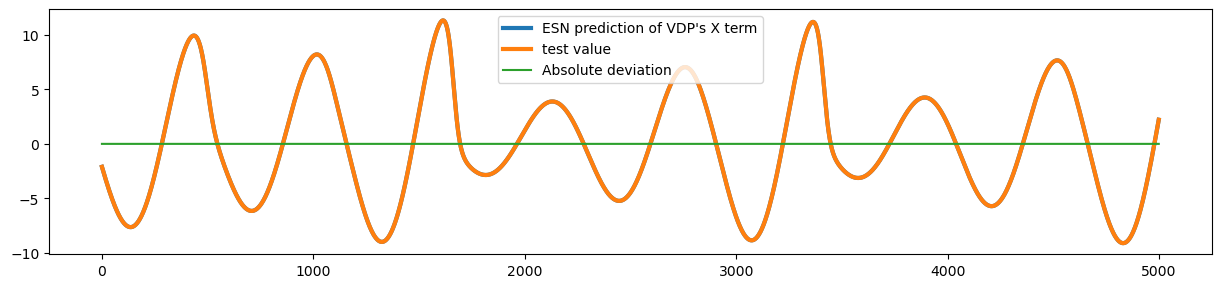

In [191]:
fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(np.arange(sample), predictions[:, :1][:sample], lw=3, label="ESN prediction of VDP's X term")
plt.plot(np.arange(sample), y_test[:, :1][:sample], lw=3, label="test value")
plt.plot(np.abs(y_test[:, :1][:sample] - predictions[:, :1][:sample]), label="Absolute deviation")

plt.legend()
plt.show()

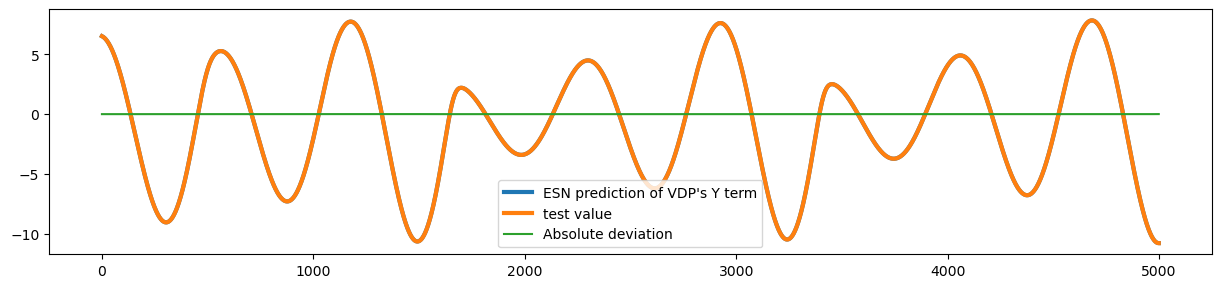

In [192]:
fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(np.arange(sample), predictions[:, 1:2][:sample], lw=3, label="ESN prediction of VDP's Y term")
plt.plot(np.arange(sample), y_test[:, 1:2][:sample], lw=3, label="test value")
plt.plot(np.abs(y_test[:, 1:2][:sample] - predictions[:, 1:2][:sample]), label="Absolute deviation")

plt.legend()
plt.show()

### 5. Generative Modelを使ってみる．

In [193]:
def plot_generation(X_gen, X_t, nb_generations, warming_out=None, warming_inputs=None, seed_timesteps=0):
    plt.figure(figsize=(15, 5))
    if warming_out is not None:
        plt.plot(np.vstack([warming_out, X_gen]), label="Generated timeseries")
    else:
        plt.plot(X_gen, label="Generated timeseries")

    plt.plot(np.arange(nb_generations) + seed_timesteps, X_t, linestyle="--", label="Real timeseries")

    # `warming_inputs`のサイズを検証して調整します。
    if warming_inputs is not None and len(warming_inputs) > seed_timesteps:
        # `seed_timesteps`に合わせてサイズを調整
        warming_inputs = warming_inputs[:seed_timesteps]
        plt.plot(warming_inputs, linestyle="--", label="Warmup")

    plt.plot(np.arange(nb_generations) + seed_timesteps, np.abs(X_t - X_gen), label="Absolute deviation")

    if seed_timesteps > 0:
        plt.fill_between([0, seed_timesteps], *plt.ylim(), facecolor='lightgray', alpha=0.5, label="Warmup period")

    plt.legend()
    plt.show()


In [194]:
def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
    readout = Ridge(ridge=ridge)

    return reservoir >> readout

In [195]:
esn = reset_esn()

train_len = 5000

x, y = to_forecasting(X, forecast=1)
X_train3, y_train3 = x[:train_len], y[:train_len]
X_test3, y_test3 = x[train_len:], y[train_len:]

esn = esn.fit(X_train3, y_train3)

In [196]:
seed_timesteps = 3000

warming_inputs = X_test3[:seed_timesteps]

warming_out = esn.run(warming_inputs, reset=True)  # warmup

In [197]:
nb_generations = 400

X_gen = np.zeros((nb_generations, 2))
y = warming_out[-1]
for t in range(nb_generations):  # generation
    y = esn(y)
    X_gen[t, :] = y

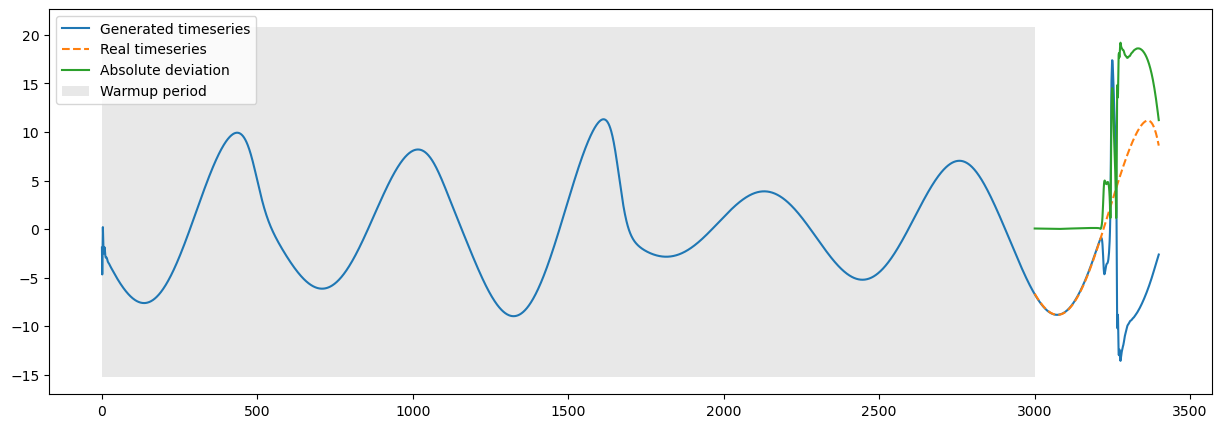

In [198]:
X_t = X_test3[seed_timesteps: nb_generations+seed_timesteps]
plot_generation(X_gen[:, :1], X_t[:, :1], nb_generations, warming_out=warming_out[:, :1],
                warming_inputs=warming_inputs[:, :1], seed_timesteps=seed_timesteps)

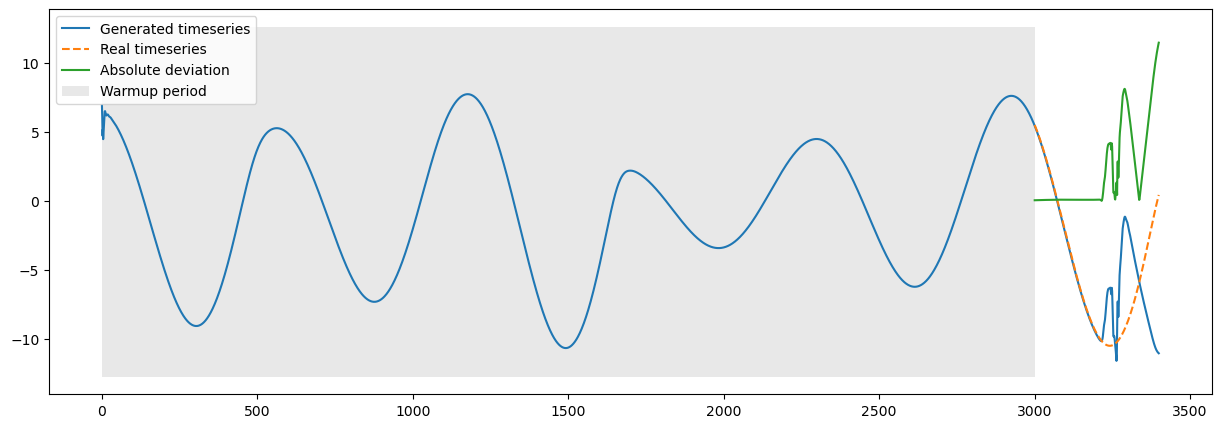

In [199]:
X_t = X_test3[seed_timesteps: nb_generations+seed_timesteps]
plot_generation(X_gen[:, 1:2], X_t[:, 1:2], nb_generations, warming_out=warming_out[:, 1:2],
                warming_inputs=warming_inputs[:, 1:2], seed_timesteps=seed_timesteps)

### 6. Generative Modelを関数化してみる．

In [200]:
import numpy as np

def generate_forecast(train_len, N, sr, lr, iss, seed, ridge, forecast, seed_timesteps, nb_generations, X):
    def reset_esn(N, sr, lr, iss, seed, ridge):
        from reservoirpy.nodes import Reservoir, Ridge

        reservoir = Reservoir(N, 
                              sr=sr, 
                              lr=lr, 
                              input_scaling=iss, 
                              seed=seed)
        readout = Ridge(ridge=ridge)

        return reservoir >> readout

    # Initialize the Echo State Network (ESN)
    esn = reset_esn(N, sr, lr, iss, seed, ridge)

    # Split the data into training and testing
    x, y = to_forecasting(X, forecast=forecast)
    X_train, y_train = x[:train_len], y[:train_len]
    X_test, y_test = x[train_len:], y[train_len:]

    # Fit the ESN
    esn = esn.fit(X_train, y_train)

    # Warm-up with seed timesteps
    warming_inputs = X_test[:seed_timesteps]
    warming_out = esn.run(warming_inputs, reset=True)

    # Generate future data
    X_gen = np.zeros((nb_generations, 2))
    y = warming_out[-1]
    for t in range(nb_generations):  # generation
        y = esn(y)
        X_gen[t, :] = y

    # Actual test data for comparison
    X_t = X_test[seed_timesteps: nb_generations+seed_timesteps]

    return X_gen, X_t


In [201]:
N = best_params_loaded['N']+500
iss = best_params_loaded['iss']
lr = best_params_loaded['lr']
ridge = best_params_loaded['ridge']
seed = best_params_loaded['seed']+1234
sr = best_params_loaded['sr']
forecast = 1
train_len = 5000
seed_timesteps = 3000
nb_generations = 1000

In [202]:
X_gen, X_t = generate_forecast(train_len, N, sr, lr, iss, seed, ridge, forecast, seed_timesteps, nb_generations, X)

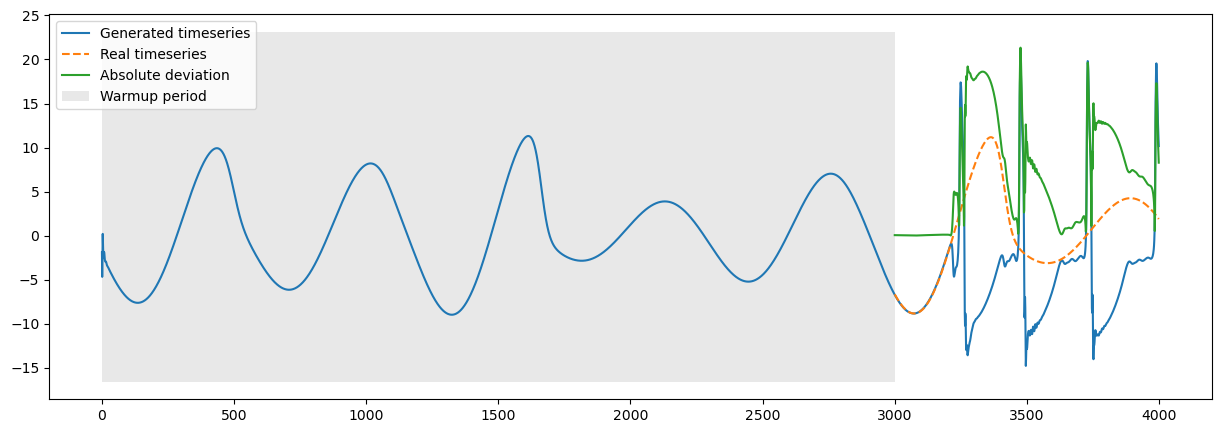

In [203]:
plot_generation(X_gen[:, :1], X_t[:, :1], nb_generations, warming_out=warming_out[:, :1],
                warming_inputs=warming_inputs[:, :1], seed_timesteps=seed_timesteps)

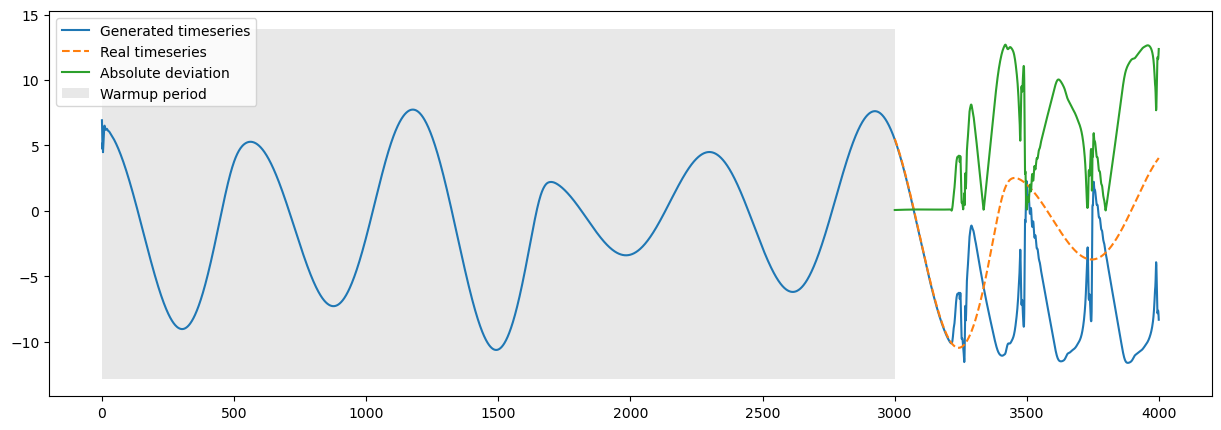

In [204]:
plot_generation(X_gen[:, 1:2], X_t[:, 1:2], nb_generations, warming_out=warming_out[:, 1:2],
                warming_inputs=warming_inputs[:, 1:2], seed_timesteps=seed_timesteps)

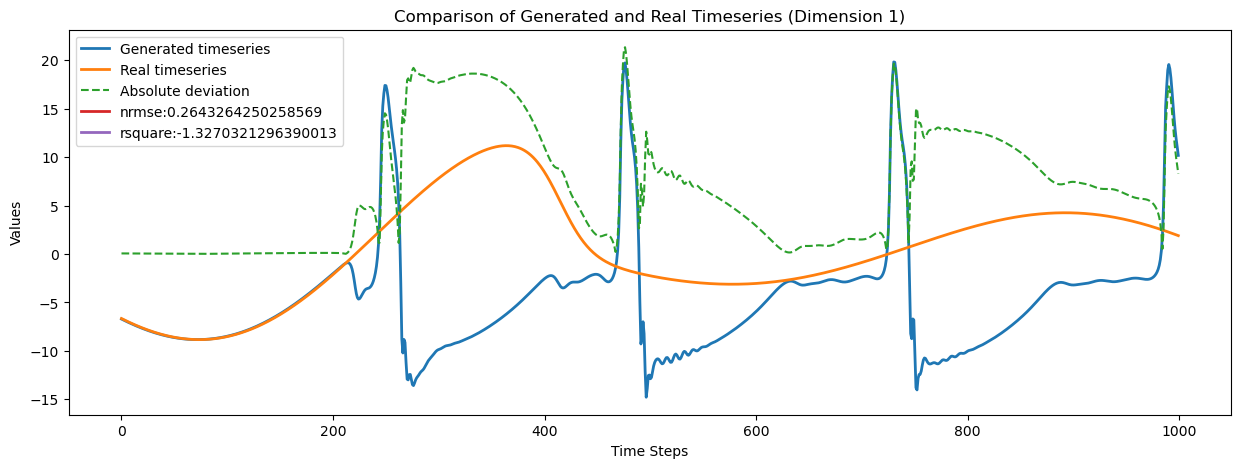

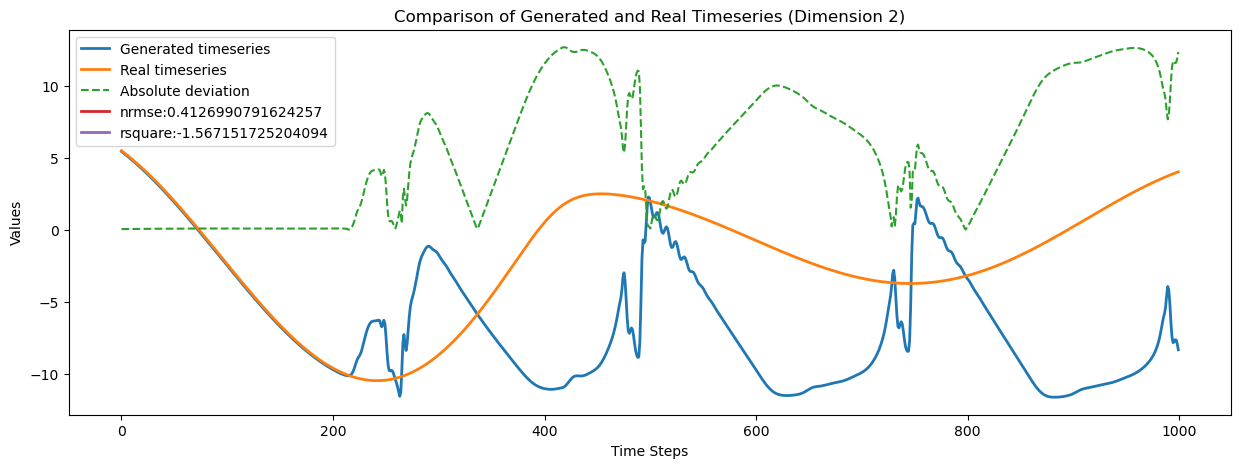

In [205]:
# 時系列データの比較を行う関数
def compare_timeseries_multidimensional(X_gen, X_t):
    num_dimensions = X_gen.shape[1]  # 次元数を取得
    for dim in range(num_dimensions):
        plt.figure(figsize=(15, 5))
        plt.plot(X_gen[:, dim], label="Generated timeseries", linewidth=2)
        plt.plot(X_t[:, dim], label="Real timeseries", linewidth=2)
        plt.plot(np.abs(X_t[:, dim] - X_gen[:, dim]), label="Absolute deviation", linestyle='--')
        plt.plot(nrmse(X_gen[:, dim], X_t[:, dim]), label=f"nrmse:{nrmse(X_gen[:, dim], X_t[:, dim])}", linewidth=2)
        plt.plot(rsquare(X_gen[:, dim], X_t[:, dim]), label=f"rsquare:{rsquare(X_gen[:, dim], X_t[:, dim])}", linewidth=2)

        plt.title(f'Comparison of Generated and Real Timeseries (Dimension {dim+1})')
        plt.xlabel('Time Steps')
        plt.ylabel('Values')
        plt.legend()        
        plt.show()

# 使用例:
compare_timeseries_multidimensional(X_gen, X_t)

やはり予測できている期間が短い
（ここでのグラフの幅1000は実際に10ステップに相当する，予測できている期間は大体2ステップ程度）．

そもそも最適化がうまくいってないのではないだろうか．

試しに，異なるパラメータに対して最適化を行ってみる．

### 7. 異なるパラメータを用いる．

In [212]:
N = best_params_loaded['N']+500
iss = 0.059936189081400526
lr = 0.38264094967620654
ridge = 1.8102732550311867e-05
seed = best_params_loaded['seed']+1234
sr = 0.07966435869333038
forecast = 1
train_len = 5000
seed_timesteps = 3000
nb_generations = 1000

In [213]:
# モデルの構築
reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
readout = Ridge(ridge=ridge)
model = reservoir >> readout

# モデルの訓練と予測
predictions = model.fit(X_train, y_train).run(X_test)

# 評価（lossとr2の計算方法は既存のものを使用しています）
loss = nrmse(y_test, predictions, norm_value=np.ptp(X_train))
r2 = rsquare(y_test, predictions)

print("Loss:", loss)
print("R^2:", r2)

Loss: 0.0002291781116396376
R^2: 0.9999991067913645


先ほどよりもLossが大きくなっていることがわかる．

参考：先ほどのパラメータでは，

Loss: 4.28484108389633e-05

R^2: 0.9999999687768958

In [214]:
sample = 4999

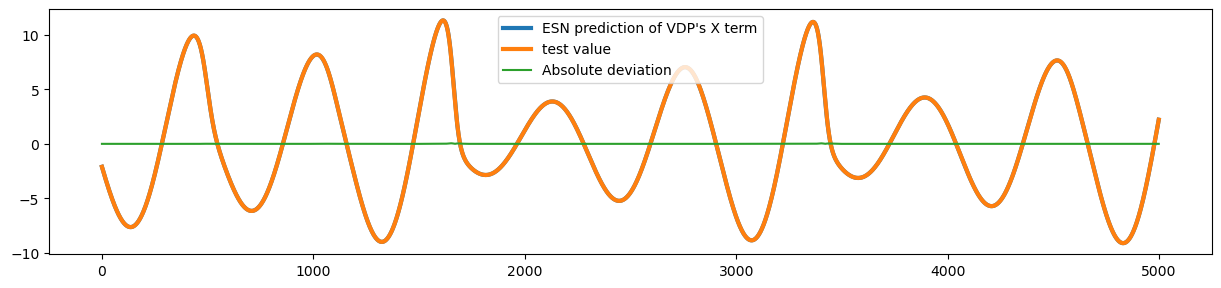

In [215]:
fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(np.arange(sample), predictions[:, :1][:sample], lw=3, label="ESN prediction of VDP's X term")
plt.plot(np.arange(sample), y_test[:, :1][:sample], lw=3, label="test value")
plt.plot(np.abs(y_test[:, :1][:sample] - predictions[:, :1][:sample]), label="Absolute deviation")

plt.legend()
plt.show()

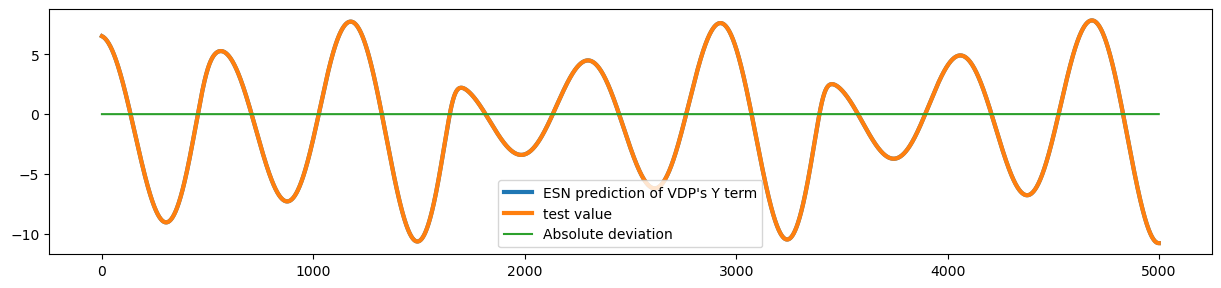

In [216]:
fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(np.arange(sample), predictions[:, 1:2][:sample], lw=3, label="ESN prediction of VDP's Y term")
plt.plot(np.arange(sample), y_test[:, 1:2][:sample], lw=3, label="test value")
plt.plot(np.abs(y_test[:, 1:2][:sample] - predictions[:, 1:2][:sample]), label="Absolute deviation")

plt.legend()
plt.show()

In [207]:
X_gen, X_t = generate_forecast(train_len, N, sr, lr, iss, seed, ridge, forecast, seed_timesteps, nb_generations, X)

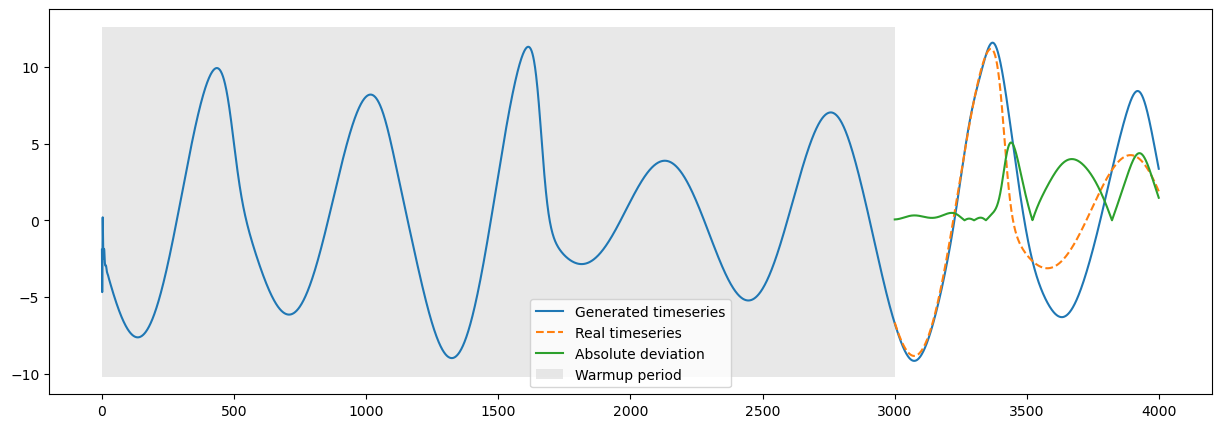

In [208]:
plot_generation(X_gen[:, :1], X_t[:, :1], nb_generations, warming_out=warming_out[:, :1],
                warming_inputs=warming_inputs[:, :1], seed_timesteps=seed_timesteps)

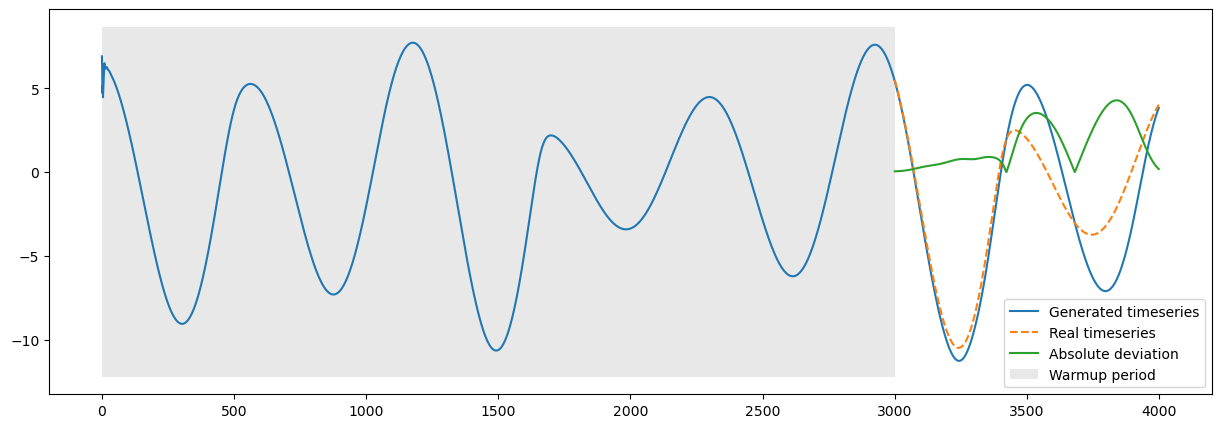

In [209]:
plot_generation(X_gen[:, 1:2], X_t[:, 1:2], nb_generations, warming_out=warming_out[:, 1:2],
                warming_inputs=warming_inputs[:, 1:2], seed_timesteps=seed_timesteps)

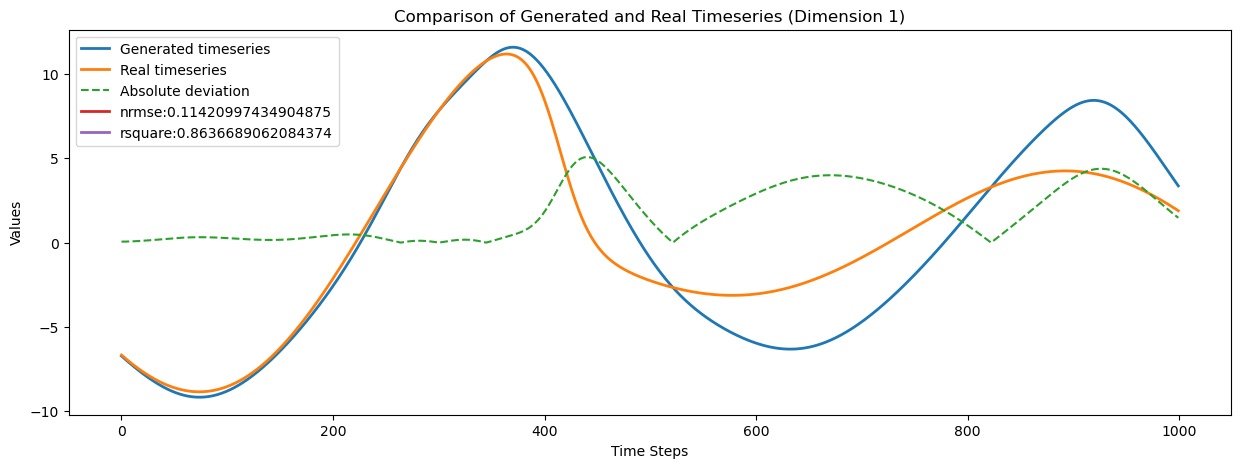

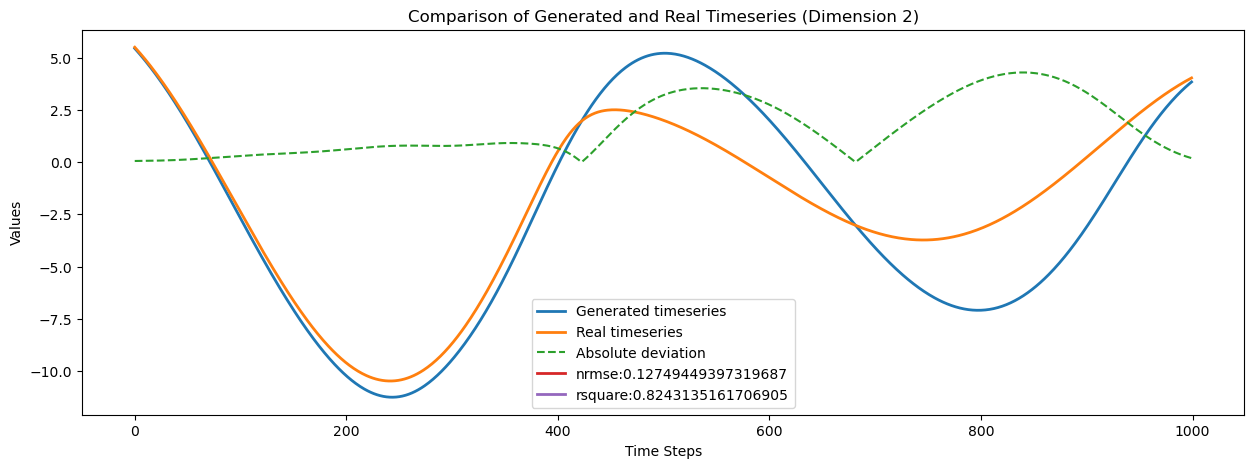

In [210]:
compare_timeseries_multidimensional(X_gen, X_t)

すると，予測できる期間が少し伸びているようだ（早い段階から誤差が生まれているように見えるが，hyperparameterの設定が初期値と期間の異なるシミュレーションに対するものだからであると予想する．すなわち，同じシミュレーションをすれば，なお良い結果が得られるかもしれない）

というか，単純にシミュレーションを長くすれば良いだけでは？

やるべきこと

1. 異なる初期値と長さのシミュレーションに対して，1.0~1.1を行うファイルを作成する．
2. 外力のある場合に対して，1.0~1.1を行うファイルを作成する．
3. 外力のある場合に対して，最も予測の良いパラメータをどうにかして発見する．
4. 外力のある場合に対して，外力の項を修正しながらgenerative modelを予測する方法を実践する．